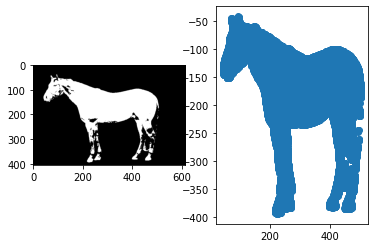

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# read in image and convert to black and white
horse = cv2.imread('horse.png')
grey_horse = cv2.cvtColor(horse, cv2.COLOR_BGR2GRAY)
(thresh, white_horse) = cv2.threshold(grey_horse, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# initialise arrays to store positions of each pixel
x_pixels = np.zeros(len(white_horse.flatten()))
y_pixels = np.zeros(len(white_horse.flatten()))

# store position of each pixel
count = 0
for row in range(white_horse.shape[0]):
    for column in range(white_horse.shape[1]):
        if white_horse[row,column] != 0:
            x_pixels[count] = column
            y_pixels[count] = -row
        count += 1 

# remove datapoints where there are no pixels
x_pixels = x_pixels[x_pixels != 0]
y_pixels = y_pixels[y_pixels != 0]

# plot
fig, ax = plt.subplots(1 , 2)

ax[0].imshow(white_horse, cmap='gray')
ax[1].scatter(x_pixels, y_pixels)

plt.show()